# 2023 CVE CWE Review 

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2023}.json.zip 
!unzip -o "*.zip" 
!wget https://raw.githubusercontent.com/CVEProject/cve-website/dev/src/assets/data/CNAsList.json

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import calplot
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('Rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2023-01-01') & (nvd['Published']  < '2024-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2023, 1, 1)
enddate  = date(2024, 1, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

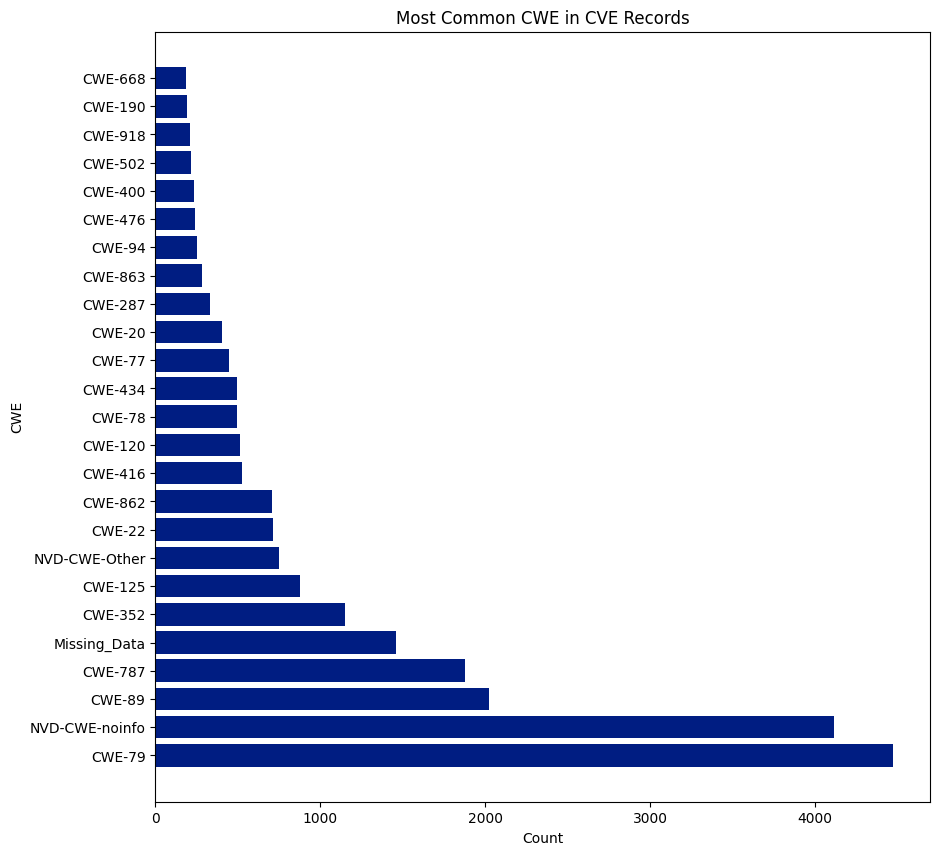

In [4]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'Counts']
nvd_cwe['Percentage'] = ( nvd_cwe['Counts'] / 
                       nvd_cwe['Counts'].sum()) * 100
nvd_cwe_graph = nvd_cwe[nvd_cwe.Counts > 100].head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "Counts", data = nvd_cwe_graph, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");

In [5]:
nvd_cwe.head(25).round(2)

,CWE,Counts,Percentage
0,CWE-79,4474,15.48
1,NVD-CWE-noinfo,4113,14.23
2,CWE-89,2021,6.99
3,CWE-787,1876,6.49
4,Missing_Data,1460,5.05
5,CWE-352,1149,3.98
6,CWE-125,878,3.04
7,NVD-CWE-Other,751,2.60
8,CWE-22,711,2.46
9,CWE-862,707,2.45


In [6]:
nvd_cwe.loc[nvd_cwe['Counts'] == 1].head(50)

,CWE,Counts,Percentage
187,CWE-612,1,0.00346
188,CWE-915,1,0.00346
189,CWE-540,1,0.00346
190,CWE-822,1,0.00346
191,CWE-636,1,0.00346
192,CWE-278,1,0.00346
193,CWE-839,1,0.00346
194,CWE-303,1,0.00346
195,CWE-836,1,0.00346
196,CWE-645,1,0.00346


In [7]:
nvd_cwe.loc[nvd_cwe['Counts'] == 1].describe()

,Counts,Percentage
count,86.0,8.600000e+01
mean,1.0,3.459968e-03
std,0.0,1.308673e-18
min,1.0,3.459968e-03
25%,1.0,3.459968e-03
50%,1.0,3.459968e-03
75%,1.0,3.459968e-03
max,1.0,3.459968e-03


In [8]:
nvd_cwe.describe()

,Counts,Percentage
count,273.000000,273.000000
mean,105.868132,0.366300
std,427.477688,1.479059
min,1.000000,0.003460
25%,1.000000,0.003460
50%,5.000000,0.017300
75%,44.000000,0.152239
max,4474.000000,15.479898
